<a href="https://colab.research.google.com/github/alexandrakraeva/IAAC2024_tutorials/blob/main/notebooks/03_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/STASYA00/IAAC2024_tutorials/blob/main/quickstarts/03_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> - Stasja's notebook

In [77]:
!pip install ortools ipykernel plotly nbformat

In [78]:
# !pip install --upgrade nbformat

* [Ortools package](https://developers.google.com/optimization)
* [What is optimization](https://en.wikipedia.org/wiki/Mathematical_optimization)
* [Video on what optimization is](https://youtu.be/AM6BY4btj-M?t=170&si=FUAW-bzml27y61zq) - only 2.50 - 6.00

## üïçOptimizing house placement

In [79]:
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

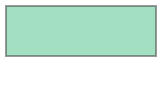

In [80]:
width = 150
depth = 50
x1 = 0
y1 = 0
coords = [(x1, y1), (x1 + width, y1), (x1+width, y1+depth), (x1, y1+depth), (x1, y1)]
house = Polygon(coords)
house

Site geometry

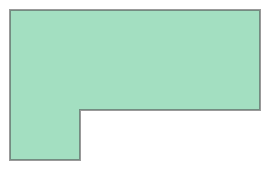

In [81]:
coords = [(0, 0), (70, 0), (70, 50), (250, 50), (250, 150), (0, 150), (0,0)]
site = Polygon(coords)
site

### Optimizing house position

We will be using [CP-SAT](https://developers.google.com/optimization/cp/cp_solver) solver made available to general public by Google.

In [82]:
from ortools.sat.python import cp_model
model = cp_model.CpModel()

Let's place our house onto the site. The constraints would be that:
* all house coordinates are within the site polygon

In [83]:
site.bounds

(0.0, 0.0, 250.0, 150.0)

In [84]:
# Int var says that we create an integer variable that can have any value in a certain range.
# This range is given when we define the variable: here it is 0 and the maximum coordinate of our site (250):
x1 = model.NewIntVar(0, int(max(site.bounds)), 'x1')  # last argument is the name of the variable in the model
x1

x1(0..250)

In [85]:
# The rest of the house coordinates
x2 = model.NewIntVar(0, int(max(site.bounds)), 'x2')
y1 = model.NewIntVar(0, int(max(site.bounds)), 'y1')
y2 = model.NewIntVar(0, int(max(site.bounds)), 'y2')

Now let's add the relationship between the coordinates and tell our model that x2 - x1 = width

In [86]:
model.Add(x2-x1==width)
model.Add(y2-y1==depth)

# Note that our house does not rotate at the moment. We are only placing it vertically.

In [87]:
model.Add(x1 < int(site.bounds[2]))
model.Add(y1 < int(site.bounds[3]))
model.Add(x2 < int(site.bounds[2]))
model.Add(y2 < int(site.bounds[3]))

In [88]:
model.Minimize(y2)

In [89]:
solver = cp_model.CpSolver()
status = solver.Solve(model)
status

4

In [90]:
print("x1:", solver.Value(x1))
print("x2:", solver.Value(x2))
print("y1:", solver.Value(y1))
print("y2:", solver.Value(y2))

x1: 0
x2: 150
y1: 0
y2: 50


In [91]:
house_location = Polygon([
    (solver.Value(x1), solver.Value(y1)),
    (solver.Value(x2), solver.Value(y1)),
    (solver.Value(x2), solver.Value(y2)),
    (solver.Value(x1), solver.Value(y2)),
    (solver.Value(x1), solver.Value(y1))])

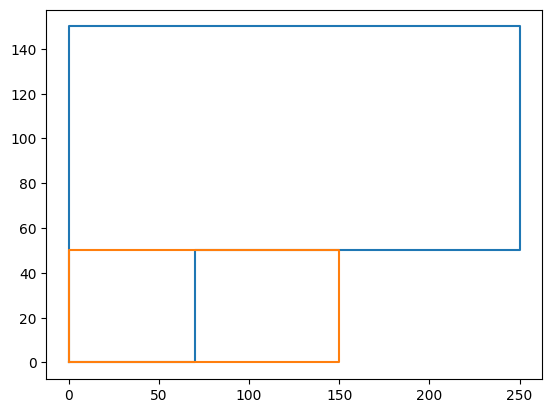

In [92]:
plt.plot(*site.exterior.xy)
plt.plot(*house_location.exterior.xy)

In [93]:
def plot_result(slvr):
    print("x1:", slvr.Value(x1))
    print("x2:", slvr.Value(x2))
    print("y1:", slvr.Value(y1))
    print("y2:", slvr.Value(y2))

    house_location = Polygon([
    (solver.Value(x1), solver.Value(y1)),
    (solver.Value(x2), solver.Value(y1)),
    (solver.Value(x2), solver.Value(y2)),
    (solver.Value(x1), solver.Value(y2)),
    (solver.Value(x1), solver.Value(y1))])

    plt.plot(*site.exterior.xy)
    plt.plot(*house_location.exterior.xy)


Let's adjust our constraints:

In [95]:
model = cp_model.CpModel()
x1 = model.NewIntVar(0, int(max(site.bounds)), 'x1')
x2 = model.NewIntVar(0, int(max(site.bounds)), 'x2')
y1 = model.NewIntVar(0, int(max(site.bounds)), 'y1')
y2 = model.NewIntVar(0, int(max(site.bounds)), 'y2')

model.Add(x2-x1==width)
model.Add(y2-y1==depth)

model.Add(x1 < int(site.bounds[2]))
model.Add(y1 < int(site.bounds[3]))
model.Add(x2 < int(site.bounds[2]))
model.Add(y2 < int(site.bounds[3]))

In [96]:
x1_outside = model.NewBoolVar("x1_outside")  # true if x1 > 70 -> in the question zone
x2_outside = model.NewBoolVar("x2_outside")  # true if x2 > 70 -> in the question zone

In [97]:
model.Add(x1>=70).OnlyEnforceIf(x1_outside)
model.Add(x1<70).OnlyEnforceIf(x1_outside.Not())
model.Add(x2>=70).OnlyEnforceIf(x2_outside)
model.Add(x2<70).OnlyEnforceIf(x2_outside.Not())

In [98]:
model.Add(y1>=50).OnlyEnforceIf(x1_outside)  # if x coordinate is in the "outside zone" y coordinate can only be from 50 to 150
model.Add(y1>=50).OnlyEnforceIf(x2_outside)
model.Add(y2>=50).OnlyEnforceIf(x1_outside)
model.Add(y2>=50).OnlyEnforceIf(x2_outside)

In [99]:
model.Minimize(y2)
solver = cp_model.CpSolver()
status = solver.Solve(model)
status

4

In [100]:
solver.status_name()

'OPTIMAL'

x1: 69
x2: 219
y1: 50
y2: 100


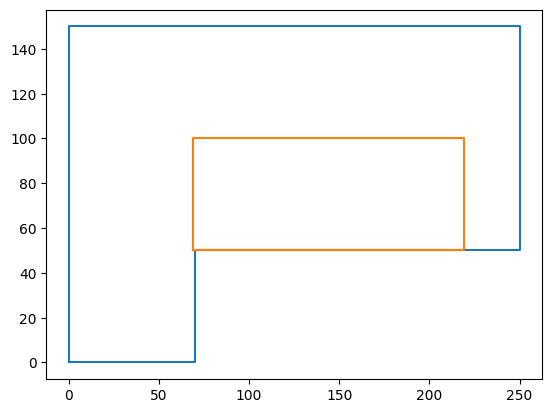

In [101]:
plot_result(solver)

### üß© Task I - multiple houses

We learnt how to place a single house on a given site. Let's say we have multiple houses and our goal is to fit as many as possible on a site.

Assume that there are no regulations on distance between the houses.

__Hint:__
* take a look at [2d bin packing](https://yetanothermathprogrammingconsultant.blogspot.com/2021/02/2d-bin-packing-with-google-or-tools-cp.html), feel free to adjust the code
* use [interval var](https://developers.google.com/optimization/reference/python/sat/python/cp_model#newintervalvar)
* use [AddNoOverlap2D](https://developers.google.com/optimization/reference/python/sat/python/cp_model#addnooverlap2d)

In [110]:
# site_coords = [(0, 0), (70, 0), (70, 50), (250, 50), (250, 150), (0, 150), (0,0)]
site_coords = [(0,0), (200, 0), (200, 400), (400, 0), (0,0)]  # simplified version

In [111]:
# houses are presented as width and height
houses = [
    [20, 40],
    [25, 40],
    [70, 100],
    [75, 30],
    [30, 30],
    [30, 30],
    [12, 25],
    [12, 20],
    [40, 20],
    [40, 30],
    [70, 30],
    [12, 25],
    [12, 20],
    [40, 20],
    [40, 30],
    [70, 30],
]

To get you started, we initiate the model and add a variable for each house that shows whether it is placed or not:

In [113]:
# Model
model = cp_model.CpModel()

# Variables for each house
x_vars = []
y_vars = []
width_intervals = []
depth_intervals = []
placed_vars = []

Building variables for one house (let's take number 1):

![Variables explanation](https://github.com/STASYA00/IAAC2024_tutorials/blob/main/.assets/optimization/1.jpg?raw=1)

In [114]:
for i, (width, height) in enumerate(houses):
    # Placement status of each house
    placed = model.NewBoolVar(f"placed_{i}")
    placed_vars.append(placed)

    # X and Y coordinates of the house
    x1 = model.NewIntVar(0, MAX_SITE_WIDTH - width, f"x1_{i}")
    y1 = model.NewIntVar(0, MAX_SITE_HEIGHT - height, f"y1_{i}")
    x2 = model.NewIntVar(width, MAX_SITE_WIDTH, f"x2_{i}")
    y2 = model.NewIntVar(height, MAX_SITE_HEIGHT, f"y2_{i}")

    x_vars.append(x1)
    y_vars.append(y1)

In [116]:
# Intervals for width and height
width_interval = model.NewOptionalIntervalVar(x1, width, x2, placed, f'width_interval_{i}')
depth_interval = model.NewOptionalIntervalVar(y1, height, y2, placed, f'depth_interval_{i}')

width_intervals.append(width_interval)
depth_intervals.append(depth_interval)

Complete the model with all the houses.

In [117]:
model.AddNoOverlap2D(width_intervals, depth_intervals)

![Overlap](https://github.com/STASYA00/IAAC2024_tutorials/blob/main/.assets/optimization/2.jpg?raw=1)

In [118]:
model.AddNoOverlap2D(house_widths, house_depths)

Run the solver and visualize the solution

In [119]:
model.Maximize(sum(placed_vars))

In [120]:
# Solver
solver = cp_model.CpSolver()
status = solver.Solve(model)

if status == cp_model.OPTIMAL:
    print("Max number of houses placed:", solver.ObjectiveValue())
    for i in range(len(houses)):
        if solver.Value(placed_vars[i]):
            print(f"House {i} placed at ({solver.Value(x_vars[i])}, {solver.Value(y_vars[i])})")
        else:
            print(f"House {i} not placed.")
else:
    print("The problem does not have an optimal solution.")

Max number of houses placed: 16.0
House 0 placed at (0, 0)
House 1 placed at (0, 0)
House 2 placed at (0, 0)
House 3 placed at (0, 0)
House 4 placed at (0, 0)
House 5 placed at (0, 0)
House 6 placed at (0, 0)
House 7 placed at (0, 0)
House 8 placed at (0, 0)
House 9 placed at (0, 0)
House 10 placed at (0, 0)
House 11 placed at (0, 0)
House 12 placed at (0, 0)
House 13 placed at (0, 0)
House 14 placed at (0, 0)
House 15 placed at (0, 0)


x1: 0
x2: 70
y1: 0
y2: 30


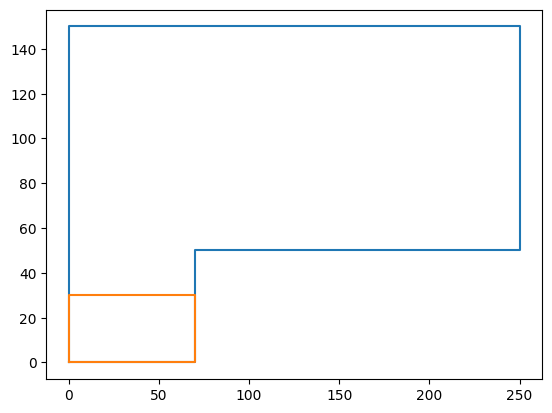

In [121]:
plot_result(solver)

### üß© Task II - adding the roads

Our houses are placed in a dense grid. Add roads, bike lanes and walkways as constraints to our model

In [ ]:
# your code here